In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
#import mpld3

# edit this to change KMeans clusters number; max 10 due to graph colors number.
num_clusters = 10

In [3]:
text_df = pd.read_csv("output/sentiment_analysis/authors_citations/ok/textblob.csv")
text_df = text_df.reindex(columns=['authid','text'])
text_df.head(3)

,authid,text
0,10041296000,Media-aware quantitative trading based on publ...
1,10042379000,A context-dependent sentiment analysis of onli...
2,10043514200,Longitudinal dynamics of the cultural diffusio...


In [4]:
stopwords = nltk.corpus.stopwords.words('english')

In [5]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [6]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [7]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for row in text_df.itertuples():
    i=row[-1]
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [8]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 5813656 items in vocab_frame


In [9]:
vocab_frame = vocab_frame.drop_duplicates()
vocab_frame.describe()
#vocab_frame.head(10)

,words
count,34561
unique,34561
top,interdependencies
freq,1


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer( max_features=20000,max_df=0.95,
                                 min_df=0.05, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                    ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(text_df['text']) #fit the vectorizer to synopses
print('tfidf_matrix has (rows(authors), cols(keywords)):')
print(tfidf_matrix.shape)

CPU times: user 2min 44s, sys: 983 ms, total: 2min 45s
Wall time: 2min 47s
tfidf_matrix has (rows(authors), cols(keywords)):
(10028, 591)


In [11]:
terms = tfidf_vectorizer.get_feature_names()
len(tfidf_vectorizer.get_feature_names())

591

In [12]:
' ,'.join(terms[:100])

"'s ,abil ,abl ,access ,accord ,account ,accur ,accuraci ,achiev ,acm ,across ,activ ,adapt ,addit ,address ,adopt ,advanc ,advantag ,affect ,aggreg ,aim ,algorithm ,allow ,along ,also ,although ,among ,amount ,analys ,analyt ,analyz ,ani ,annot ,anoth ,appli ,applic ,approach ,appropri ,area ,around ,articl ,artifici ,aspect ,assess ,assign ,associ ,attempt ,attent ,attitud ,attract ,attribut ,author ,autom ,automat ,avail ,averag ,b.v. ,base ,baselin ,basi ,basic ,bay ,becaus ,becom ,befor ,behavior ,benefit ,berlin ,best ,better ,big ,blog ,build ,built ,busi ,calcul ,call ,capabl ,captur ,carri ,case ,categor ,categori ,certain ,challeng ,chang ,characterist ,chines ,class ,classif ,classifi ,cluster ,collabor ,collect ,combin ,comment ,common ,communic ,communiti ,compani"

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
cosdist = 1 - cosine_similarity(tfidf_matrix)
np.round(cosdist,2)

array([[ 0.  ,  0.51,  0.62, ...,  0.48,  0.8 ,  0.76],
       [ 0.51,  0.  ,  0.81, ...,  0.33,  0.94,  0.81],
       [ 0.62,  0.81, -0.  , ...,  0.74,  0.72,  0.84],
       ..., 
       [ 0.48,  0.33,  0.74, ..., -0.  ,  0.87,  0.72],
       [ 0.8 ,  0.94,  0.72, ...,  0.87, -0.  ,  0.94],
       [ 0.76,  0.81,  0.84, ...,  0.72,  0.94,  0.  ]])

In [14]:
from sklearn.cluster import KMeans


km = KMeans(n_clusters=num_clusters,verbose=0,max_iter=80,n_init=3)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 36.9 s, sys: 65.7 ms, total: 37 s
Wall time: 37 s


In [15]:
output = { 'authid': list(text_df['authid']), 'cluster': clusters, 'text': list(text_df['text']) }

frame = pd.DataFrame(output, index = [clusters] , columns = ['authid', 'cluster', 'text'])

In [16]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster {} words:".format(i), end='')
    
    for ind in order_centroids[i, :10]: #replace 10 with n words per cluster
        print(' {}'.format(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]), end=',')
    print() #add whitespace
    
    print("Cluster {} has ".format(i), end='')
    print('{} authors.'.format(len(frame.ix[i]['authid'].values.tolist())))
    print() #add whitespace
    print() #add whitespace


Top terms per cluster:

Cluster 0 words: stock, market, predicting, financial, news, useful, modeling, data, article, information,
Cluster 0 has 360 authors.


Cluster 1 words: data, useful, systems, text, users, information, modeling, web, approach, language,
Cluster 1 has 2604 authors.


Cluster 2 words: reviews, product, rating, features, aspects, users, customer, opinions, online, consumers,
Cluster 2 has 871 authors.


Cluster 3 words: word, lexicon, polarized, methods, semantics, chinese, dictionaries, orientations, useful, classification,
Cluster 3 has 796 authors.


Cluster 4 words: topic, modeling, microblogging, users, propose, opinions, methods, text, based, social,
Cluster 4 has 558 authors.


Cluster 5 words: features, classification, learning, methods, useful, machine, modeling, classifying, text, domain,
Cluster 5 has 1169 authors.


Cluster 6 words: emotional, affect, modeling, text, useful, systems, users, expressed, word, classification,
Cluster 6 has 574 authors.


C

<h2>Clustering done. Visualization tips here...</h2>

We got a n_samples*n_features sparse matrix.

For high-dimensional sparse data it is helpful to <b>first reduce the dimensions to 50 dimensions with TruncatedSVD</b> and <b>then perform t-SNE</b>. 
This will usually improve the visualization.

In [17]:
#TruncatedSVD and t-SNE on cosdist matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(cosdist)
X_cosdist = TSNE(n_components=2, perplexity=40, verbose=1).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10028
[t-SNE] Computed conditional probabilities for sample 2000 / 10028
[t-SNE] Computed conditional probabilities for sample 3000 / 10028
[t-SNE] Computed conditional probabilities for sample 4000 / 10028
[t-SNE] Computed conditional probabilities for sample 5000 / 10028
[t-SNE] Computed conditional probabilities for sample 6000 / 10028
[t-SNE] Computed conditional probabilities for sample 7000 / 10028
[t-SNE] Computed conditional probabilities for sample 8000 / 10028
[t-SNE] Computed conditional probabilities for sample 9000 / 10028
[t-SNE] Computed conditional probabilities for sample 10000 / 10028
[t-SNE] Computed conditional probabilities for sample 10028 / 10028
[t-SNE] Mean sigma: 1.932745
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.197775
[t-SNE] Error after 375 iterations: 1.197775


In [18]:
#TruncatedSVD and t-SNE on tfidf_matrix

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf_matrix)
X_tfidf = TSNE(n_components=2, perplexity=40, verbose=1).fit_transform(X_reduced)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10028
[t-SNE] Computed conditional probabilities for sample 2000 / 10028
[t-SNE] Computed conditional probabilities for sample 3000 / 10028
[t-SNE] Computed conditional probabilities for sample 4000 / 10028
[t-SNE] Computed conditional probabilities for sample 5000 / 10028
[t-SNE] Computed conditional probabilities for sample 6000 / 10028
[t-SNE] Computed conditional probabilities for sample 7000 / 10028
[t-SNE] Computed conditional probabilities for sample 8000 / 10028
[t-SNE] Computed conditional probabilities for sample 9000 / 10028
[t-SNE] Computed conditional probabilities for sample 10000 / 10028
[t-SNE] Computed conditional probabilities for sample 10028 / 10028
[t-SNE] Mean sigma: 0.209622
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.191625
[t-SNE] Error after 425 iterations: 1.191625


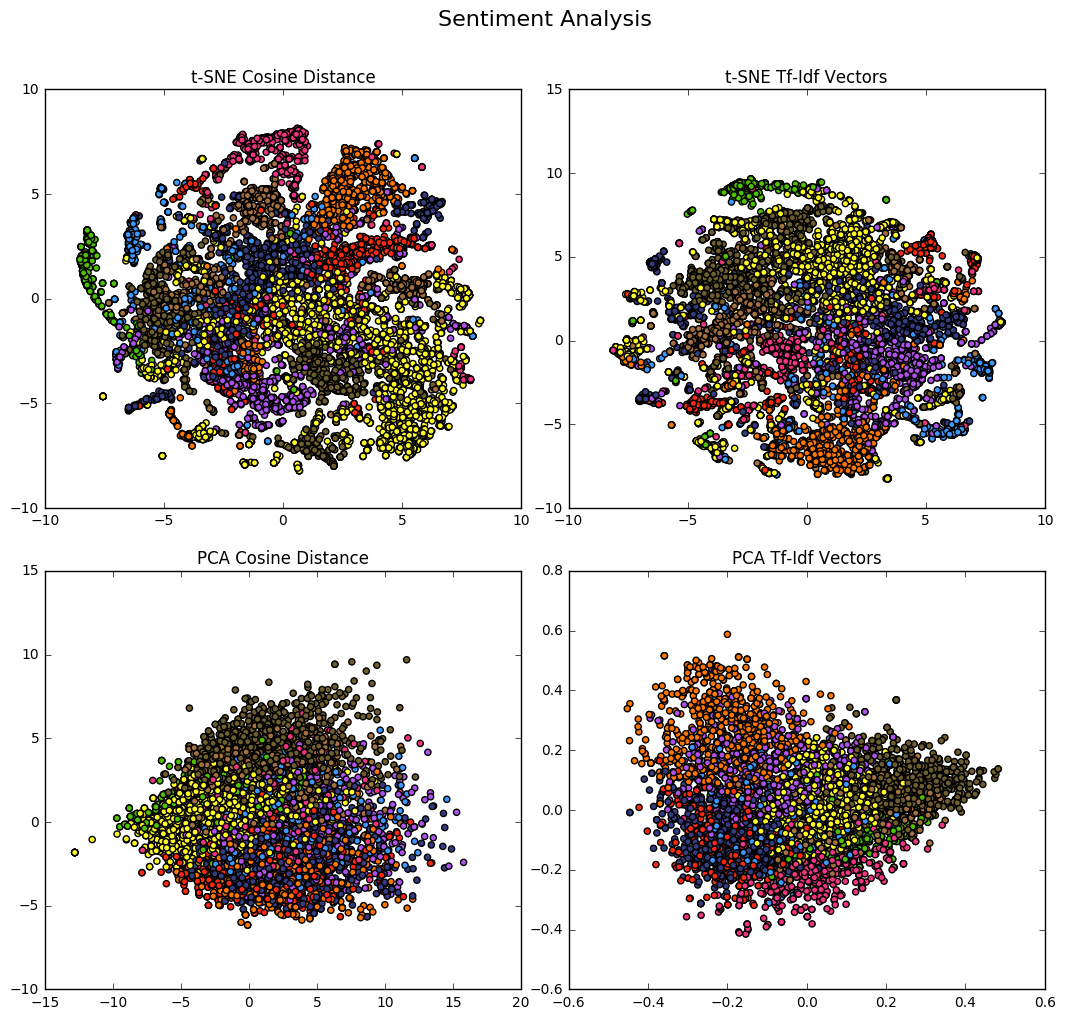

In [24]:
from sklearn.decomposition import PCA
%matplotlib inline

pca_tfidf = PCA(n_components=2).fit_transform(tfidf_matrix.toarray())
pca_cosdist = PCA(n_components=2).fit_transform(cosdist)

import matplotlib.pyplot as plt
colormap = np.array(['#4DC200', '#FFF926', '#FF7600', '#FF2813', '#3B99FF','#353d82','#f23581','#a67141','#B051EC','#6e5d2e'])

#2d plot

fig = plt.figure(figsize=(10, 10))
# plot setup
fig.suptitle("Sentiment Analysis", fontsize=16)
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.1, hspace=0.15)
# 1st plot
ax = plt.subplot("221")
ax.set_title("t-SNE Cosine Distance")
ax.scatter(X_cosdist[:, 0], X_cosdist[:, 1],
        c=colormap[km.labels_], marker="o")
# 2nd plot
ax = plt.subplot("222")
ax.set_title("t-SNE Tf-Idf Vectors")
ax.scatter(X_tfidf[:, 0], X_tfidf[:, 1],
        c=colormap[km.labels_], marker="o")
# 3rd plot
ax = plt.subplot("223")
ax.set_title("PCA Cosine Distance")
ax.scatter(pca_cosdist[:,0], pca_cosdist[:,1], c=colormap[km.labels_])

# 4th plot
ax = plt.subplot("224")
ax.set_title("PCA Tf-Idf Vectors")
ax.scatter(pca_tfidf[:,0], pca_tfidf[:,1], c=colormap[km.labels_], marker="o")


# convert this to a code cell to create and print 3D plots
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(cosdist)
tsne_3d_cosdist = TSNE(n_components=3, perplexity=40, verbose=1).fit_transform(X_reduced)

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf_matrix)
tsne_3d_tfidf = TSNE(n_components=3, perplexity=40, verbose=1).fit_transform(X_reduced)

pca_3d_tfidf = PCA(n_components=3).fit_transform(tfidf_matrix.toarray())
pca_3d_cosdist = PCA(n_components=3).fit_transform(cosdist)

fig = plt.figure(figsize=(10, 10))

fig.suptitle("Sentiment Analysis", fontsize=16)
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.1, hspace=0.15)


ax = plt.subplot("221",projection='3d')
ax.set_title("t-SNE Cosine Distance")
ax.scatter(tsne_3d_cosdist[:, 0], tsne_3d_cosdist[:, 1], tsne_3d_cosdist[:, 2],
        c=colormap[km.labels_], marker="o")

ax = plt.subplot("222",projection='3d')
ax.set_title("t-SNE Tf-Idf Vectors")
ax.scatter(tsne_3d_tfidf[:, 0], tsne_3d_tfidf[:, 1], tsne_3d_tfidf[:, 2],
        c=colormap[km.labels_], marker="o")

ax = plt.subplot("223",projection='3d')
ax.set_title("PCA Cosine Distance")
ax.scatter(pca_3d_cosdist[:, 0], pca_3d_cosdist[:, 1], pca_3d_cosdist[:, 2],
        c=colormap[km.labels_], marker="o")


ax = plt.subplot("224",projection='3d')
ax.set_title("PCA Tf-Idf Vectors")
ax.scatter(pca_3d_tfidf[:, 0], pca_3d_tfidf[:, 1], pca_3d_tfidf[:, 2],
        c=colormap[km.labels_], marker="o")

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(cosdist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=text_df['authid']);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters